In [1]:
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import os

import utility as util
import astra_wrappers 
import cost_functions 
import reconstruction_alogrithms
import new_solution_generators
import postprocessing

(64, 64)


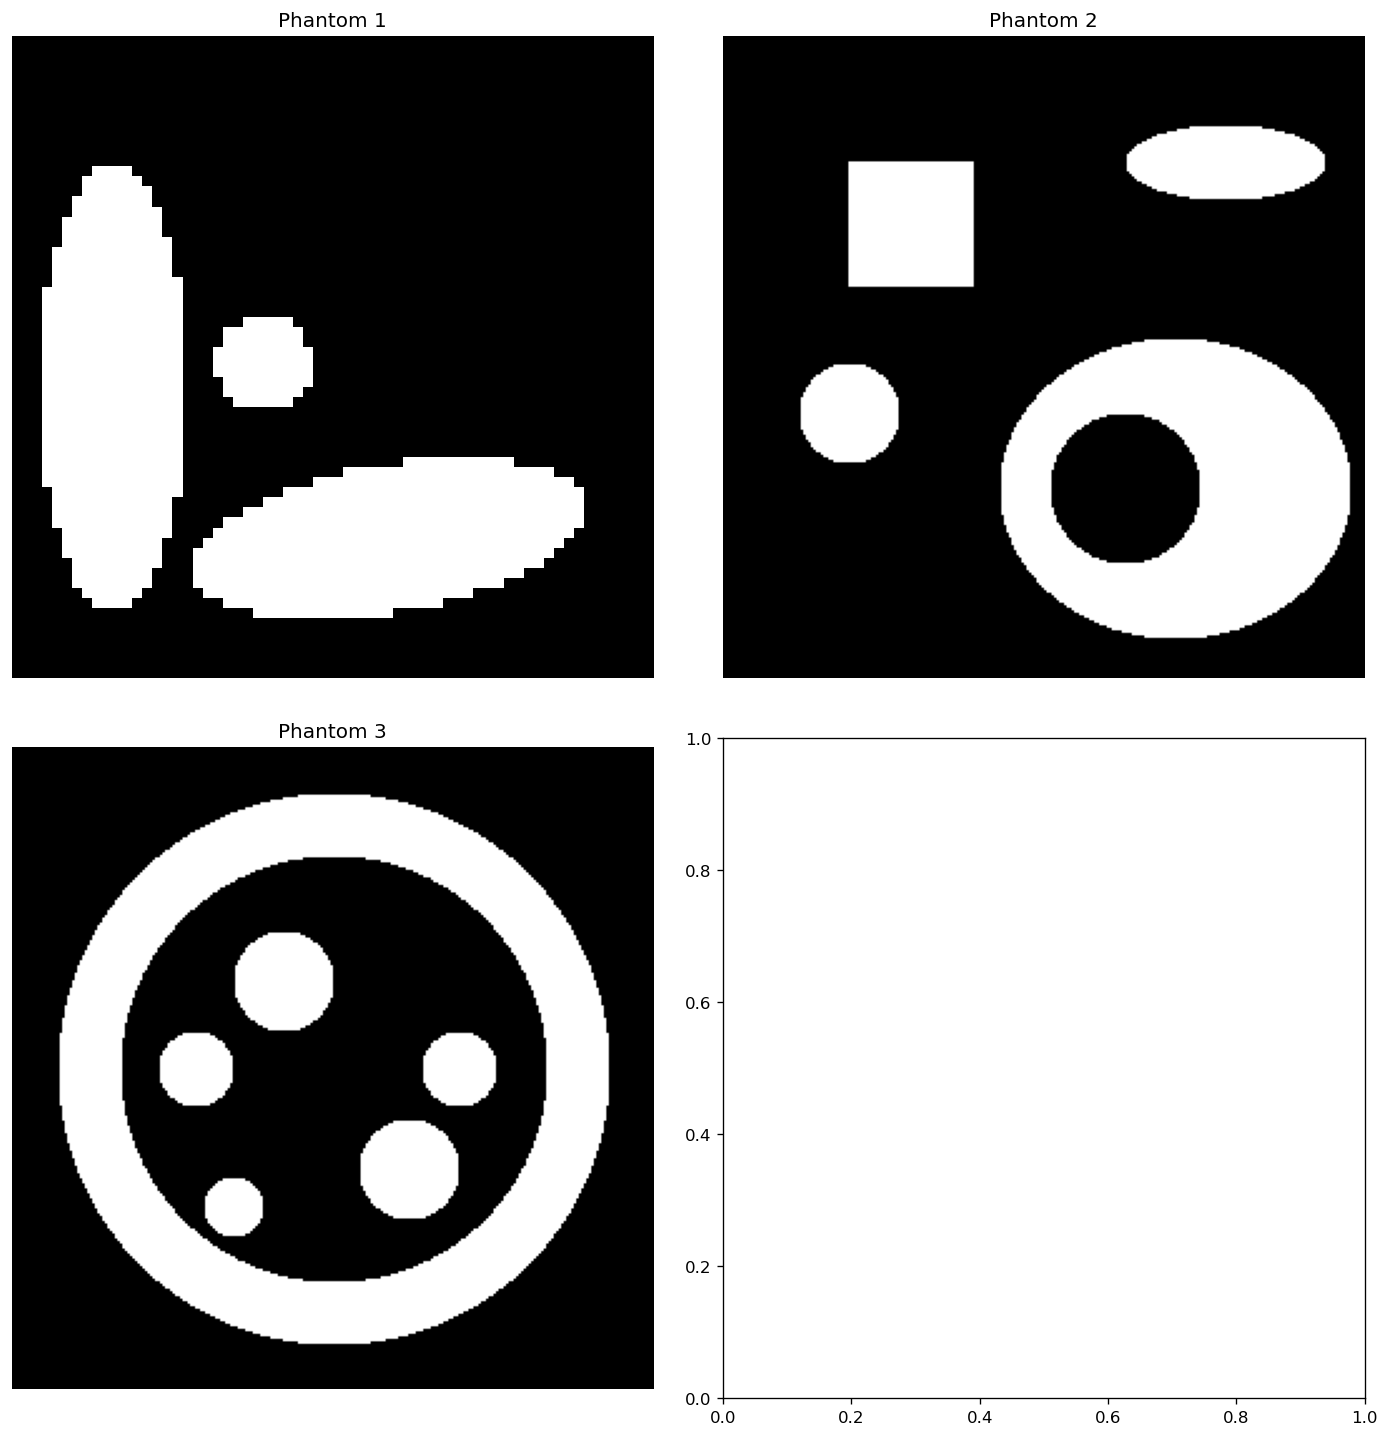

In [2]:
phantom1 = ski.io.imread(os.path.join('data', 'phantom_sz64', 'ph1.png'))
phantom1 = util.fix_img(phantom1)
phantom2 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph2.png'))
phantom2 = util.fix_img(phantom2)
phantom3 = ski.io.imread(os.path.join('data', 'phantom_sz', 'ph3.png'))
phantom3 = util.fix_img(phantom3)

images = [phantom1, phantom2, phantom3]

titles = ['Phantom 1', 'Phantom 2', 'Phantom 3']

util.plot_images(images, titles)

# 1. Simulated Annealing with Hamming distance neighbours and Gauss regularization cost function

Best cost: 154097.7313871962


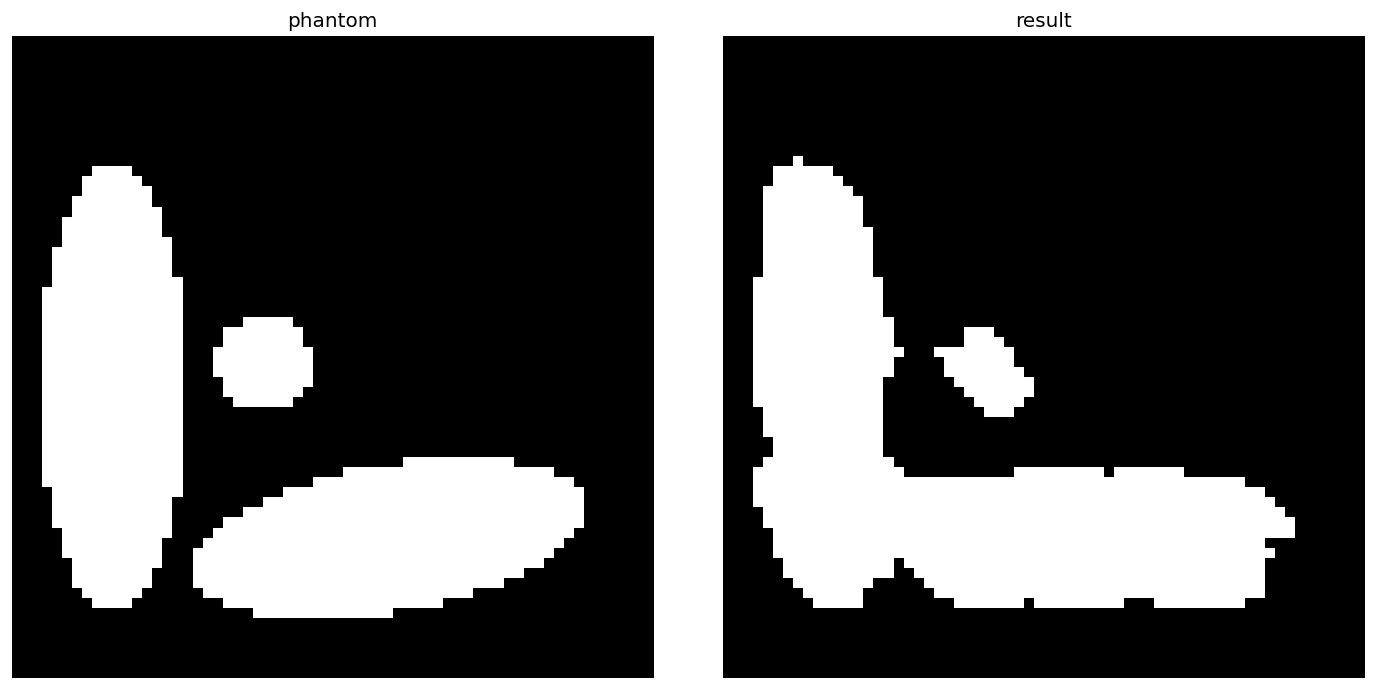

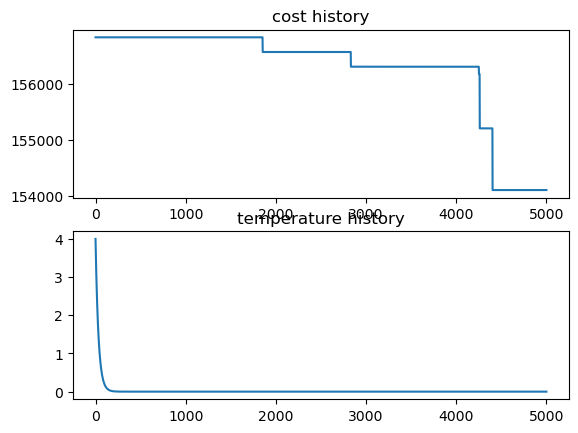

In [5]:
def SA1(image, p, M):
    """
    Simulated Annealing reconstruction.
    """
    if p < 6:
        angles = np.linspace(0, np.pi/2, p)
    else:
        angles = np.linspace(0, np.pi/2 + np.pi /3, p)

    res = astra_wrappers.preprocess_image(image, angles=angles, M=M)

    # --- Parameters---
    params = {
        "T_start": 4.0,
        "cooling_rate": 0.97,
        "max_iter": 5000,
        "epsilon": 0.00001,
        "verbose": False,

        "sigma": 0.5,  # Standard deviation for Gaussian regularization
        "r": 1,  # Regularization parameter for Gaussian regularization
        "gamma" : 14,
    }

    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_gauss_regularization,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["sigma"], params["r"], params["gamma"]),
        neighbour_function=neighbour_function,
        params=params
    )

    # SA.estimate_starting_temperature(100)
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    plot_img = [image, best_img]
    plot_titles = ['phantom', 'result']
    util.plot_images(plot_img, plot_titles)

    fig, ax = plt.subplots(2, 1)
    ax = ax.ravel()
    ax[0].plot(cost_history)
    ax[0].set_title('cost history')
    ax[1].plot(temp_history)
    ax[1].set_title('temperature history')


SA1(phantom1, p=5, M=96)



# 2. Simulated Annealing with edge changing neighbours with l2 + tv norm cost

SA.T=np.float64(365.62537657855245)
Best cost: 35.617714301648384


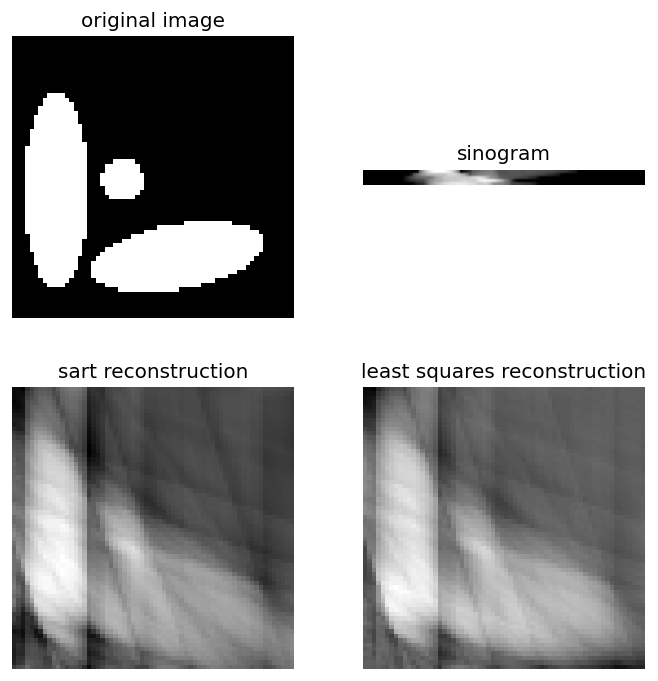

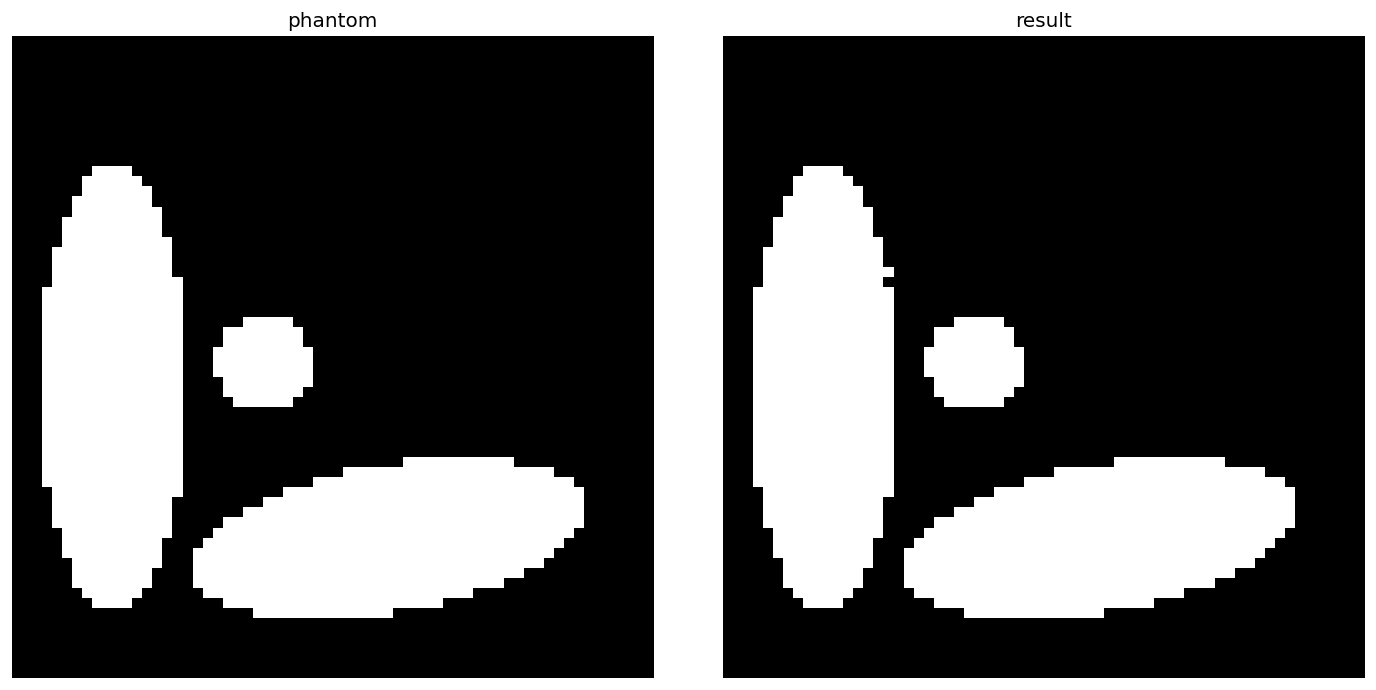

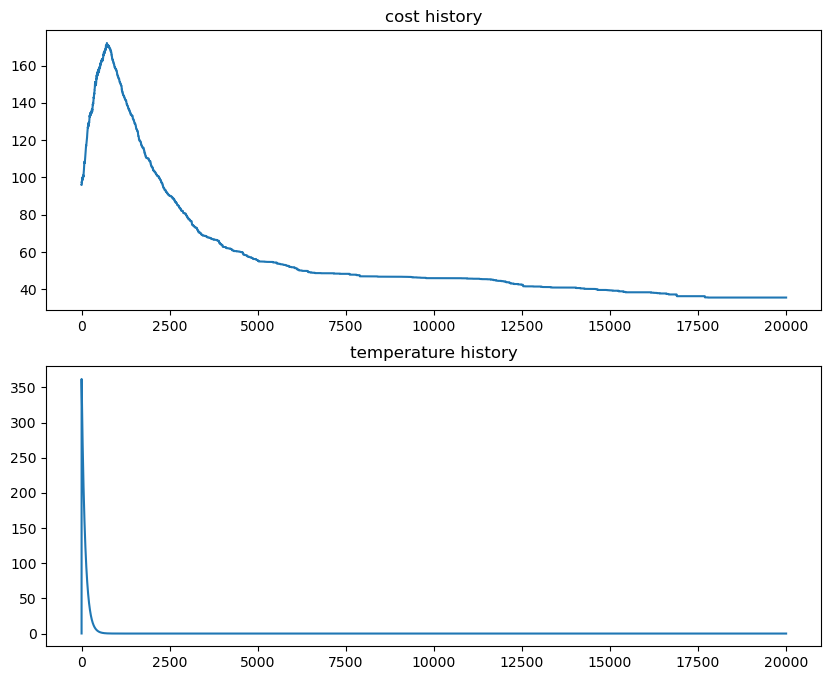

In [12]:
def SA2(image, p, M, params):
    """
    Simulated Annealing reconstruction.
    """
    if p < 6:
        angles = np.linspace(0, np.pi/2, p, endpoint=False)
    else:
        angles = np.linspace(0, np.pi/2 + np.pi /3, p, endpoint=False)

    res = astra_wrappers.preprocess_image(image, angles=angles, M=M, show_results=True)


    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    neighbour_function = new_solution_generators.FlipOnEdge(
        res["rec_art"],
        params["boundary_recalc_freq"],
    )


    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_and_tv,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["lambda_tv"]),
        neighbour_function=neighbour_function,
        params=params
    )

    SA.estimate_starting_temperature(100)
    print(f"{SA.T=}")
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    plot_img = [image, best_img]
    plot_titles = ['phantom', 'result']
    util.plot_images(plot_img, plot_titles)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax = ax.ravel()
    ax[0].plot(cost_history)
    ax[0].set_title('cost history')
    ax[1].plot(temp_history)
    ax[1].set_title('temperature history')
    

# --- Parameters---
params = {
    "T_start": 0.1,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
}
SA2(phantom1, p=5, M=96, params=params)

SA.T=np.float64(2583.5616756901304)
Best cost: 458.62017304323956


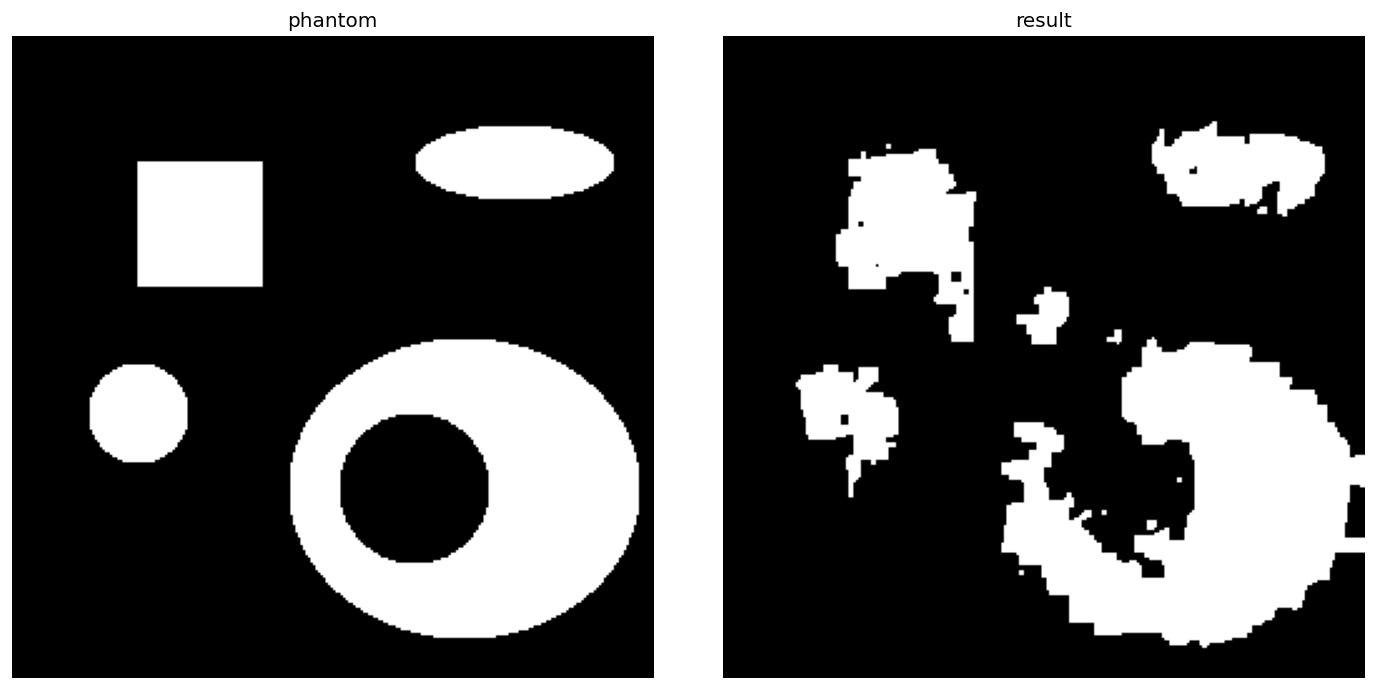

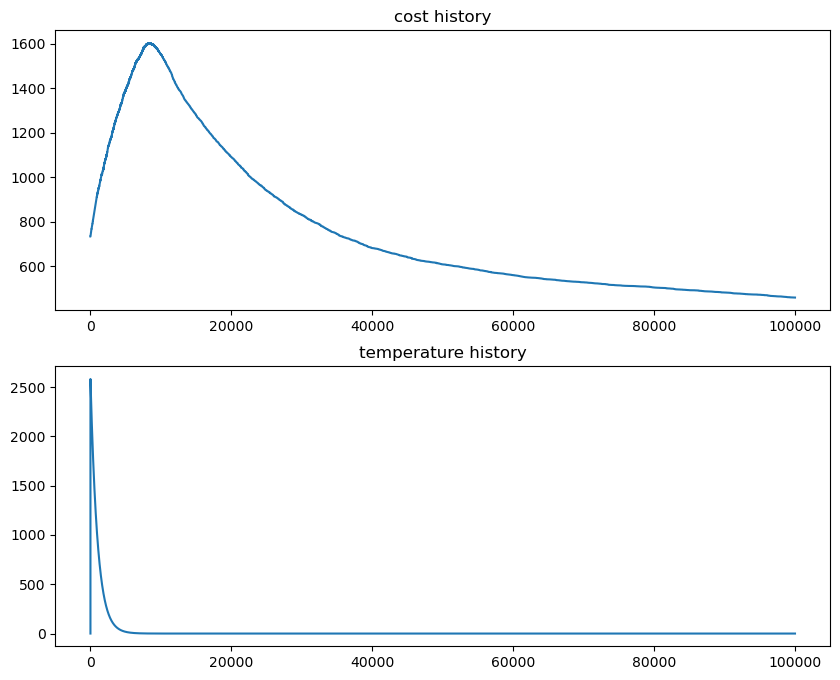

In [11]:

# --- Parameters---
params = {
    "T_start": 0.1,
    "cooling_rate": 0.999,
    "max_iter": 100000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
}
SA2(phantom2, p=5, M=384, params=params)

In [ ]:
SA2(phantom3, p=5, M=384)

In [ ]:
def SA3(image, p, M, params):
    """
    Simulated Annealing reconstruction.
    """
    if p < 6:
        angles = np.linspace(0, np.pi/2, p, endpoint=False)
    else:
        angles = np.linspace(0, np.pi/2 + np.pi /3, p, endpoint=False)

    res = astra_wrappers.preprocess_image(image, angles=angles, M=M)


    X0 = astra_wrappers.calculate_X0(res["sinogram"], res["angles"], res["rec_fbp"])

    neighbour_function = new_solution_generators.DeterioratingHammingDistance(
        max_iter=params["max_iter"],
        h_min=1,
        h_max=3
    )

    neighbour_function = new_solution_generators.FlipOnEdge(
        res["rec_art"],
        params["boundary_recalc_freq"],
        fix_high_distance_pixels=True,
        fixed_pixels_per_iter=params["fixed_pixels_per_iter"],
        max_fix_iter=params["max_fix_iter"]
    )


    SA = reconstruction_alogrithms.SimulatedAnnealing(
        X0=X0,
        cost_function=cost_functions.l2_and_tv,
        cost_function_args=(res["system_matrix"], res["sinogram"].ravel(), params["lambda_tv"]),
        neighbour_function=neighbour_function,
        params=params
    )

    SA.estimate_starting_temperature(100)
    print(f"{SA.T=}")
        
    best_img, best_cost, cost_history, temp_history = SA.run()
    print(f"Best cost: {best_cost}")
    
    plot_img = [image, best_img]
    plot_titles = ['phantom', 'result']
    util.plot_images(plot_img, plot_titles)

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax = ax.ravel()
    ax[0].plot(cost_history)
    ax[0].set_title('cost history')
    ax[1].plot(temp_history)
    ax[1].set_title('temperature history')
    

# --- Parameters---
params = {
    "T_start": 0.1,
    "cooling_rate": 0.99,
    "max_iter": 20000,
    "epsilon": 0.00001,
    "verbose": False,

    "lambda_tv": 0.001,

    "boundary_recalc_freq" : 100,
    "fixed_pixels_per_iter" : 10,
    "max_fix_iter" : 10,
}
SA3(phantom2, p=5, M=384, params=params)